In [1]:
import sys
sys.path.append("../")

import os
from pathlib import Path
from fastsim.fastsimrust import abc_to_drag_coeffs
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import seaborn as sns

import fastsim as fsim

from openbustools import standardfeeds
from openbustools.drivecycle import trajectory

In [95]:
# Load phone data
phone_trajectory_folders = [x for x in Path("..","data","kcm_sensor","match_realtime").glob("*") if x.is_dir()]
# Build trajectory for each phone recording
for phone_trajectory_folder in phone_trajectory_folders:
    # Load phone data
    metadata_phone, data_phone = standardfeeds.combine_phone_sensors(phone_trajectory_folder, "America/Los_Angeles")
    data_phone.loc[data_phone['speed']<0, 'speed'] = np.nan
    data_phone.loc[data_phone['bearing']<0, 'bearing'] = np.nan
    data_phone = data_phone.bfill()
    # Create trajectory
    phone_traj = trajectory.Trajectory(
        point_attr={
            "lon": data_phone.longitude.to_numpy(),
            "lat": data_phone.latitude.to_numpy(),
            "measured_elev_m": data_phone.altitudeAboveMeanSeaLevel.to_numpy(),
            "measured_speed_m_s": data_phone.speed.to_numpy(),
            "measured_bear_d": data_phone.bearing.to_numpy(),
            "measured_accel_m_s2": np.diff(data_phone.speed.to_numpy(), prepend=0), # Can be accelerometer or speed derivative
            "measured_theta_d": data_phone.pitch.to_numpy() - np.mean(data_phone.pitch.to_numpy()),
            "cumul_time_s": data_phone.cumul_time_s.to_numpy(),
        },
        traj_attr=metadata_phone,
        coord_ref_center=[386910, 69022],
        epsg=32148,
        apply_filter=False
    )
    phone_traj.gdf['measured_gradient_pct_100'] = phone_traj.gdf['measured_elev_m'].diff().fillna(0) / phone_traj.gdf['calc_dist_m']
    phone_traj.gdf['measured_gradient_pct_100'] = phone_traj.gdf['measured_gradient_pct_100'].fillna(0)
phone_traj.gdf.head()

,lon,lat,measured_elev_m,measured_speed_m_s,measured_bear_d,measured_accel_m_s2,measured_theta_d,cumul_time_s,geometry,x,y,x_cent,y_cent,calc_dist_m,calc_bear_d,measured_gradient_pct_100
0,-122.321067,47.620088,104.952405,0.467814,122.469540,0.467814,11.846640,0,POINT (388173.912 70023.519),388173.912196,70023.519002,1263.912196,1001.519002,0.000000,0.000000,0.000000
1,-122.321052,47.620093,104.860887,0.052638,348.242663,-0.415176,9.016270,1,POINT (388175.033 70024.110),388175.033043,70024.109840,1265.033043,1002.109840,1.267065,61.097091,-0.072228
2,-122.321039,47.620088,104.954589,0.082191,348.242663,0.029553,6.039926,2,POINT (388176.052 70023.534),388176.052473,70023.534046,1266.052473,1001.534046,1.170824,118.350965,0.080031
3,-122.321032,47.620091,105.006022,0.172272,348.242663,0.090081,12.101454,3,POINT (388176.525 70023.862),388176.524669,70023.861815,1266.524669,1001.861815,0.574817,54.126426,0.089477
4,-122.321025,47.620095,104.661322,0.427894,348.242663,0.255622,14.511643,4,POINT (388177.123 70024.260),388177.122882,70024.260056,1267.122882,1002.260056,0.718663,55.239951,-0.479642


In [167]:
# Create cycle from phone data
phone_cycle = {
    'cycGrade': np.zeros(len(phone_traj.gdf['cumul_time_s'])),
    'mps': phone_traj.gdf['measured_speed_m_s'].to_numpy(),
    'time_s': phone_traj.gdf['cumul_time_s'].to_numpy(),
    'road_type': np.zeros(len(phone_traj.gdf['cumul_time_s'])),
}

In [262]:
# Calculate cycle energy consumption
veh = fsim.vehicle.Vehicle.from_vehdb(17)
cyc = fsim.cycle.Cycle.from_file("udds")
cyc = fsim.cycle.Cycle.from_dict(phone_cycle)
cyc = fsim.cycle.Cycle.from_dict(fsim.cycle.resample(phone_cycle, new_dt=1))
sim_drive = fsim.simdrive.SimDrive(cyc, veh)
sim_drive.sim_drive()

0.513387 kWh
3.148904 miles
0.169812 kWh/mi
5.888866 mi/kWh


Text(63.875, 0.5, 'Speed [MPH]')

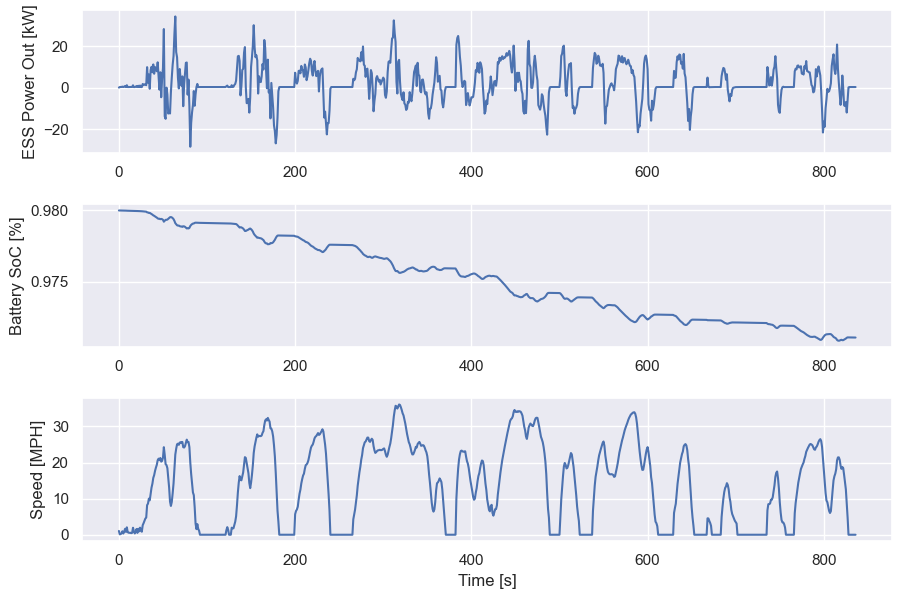

In [263]:
# Show results
print(f"{sim_drive.ess_kw_out_ach.sum() / 60 / 60:f} kWh")
print(f"{sim_drive.dist_mi.sum():f} miles")
print(f"{sim_drive.electric_kwh_per_mi:f} kWh/mi")
print(f"{1 / sim_drive.electric_kwh_per_mi:f} mi/kWh")

fig, ax = plt.subplots(3, 1, figsize=(9,6))
fig.tight_layout()
ax[0].plot(cyc.time_s, sim_drive.ess_kw_out_ach)
ax[0].set_ylabel('ESS Power Out [kW]')
ax[1].plot(cyc.time_s, sim_drive.soc)
ax[1].set_ylabel('Battery SoC [%]')
ax[2].plot(cyc.time_s, sim_drive.mph_ach)
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Speed [MPH]')

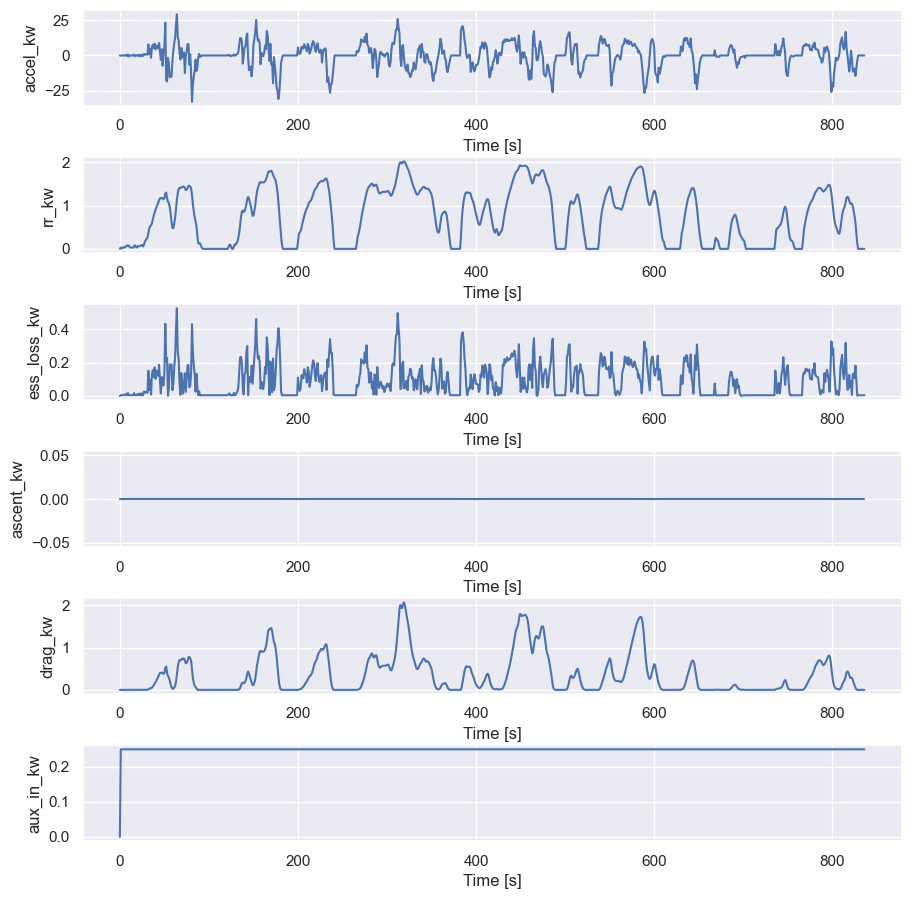

In [281]:
power_components = {
    "accel_kw": sim_drive.accel_kw,
    "rr_kw": sim_drive.rr_kw,
    "ess_loss_kw": sim_drive.ess_loss_kw,
    "ascent_kw": sim_drive.ascent_kw,
    "drag_kw": sim_drive.drag_kw,
    "aux_in_kw": sim_drive.aux_in_kw,
}
fig, ax = plt.subplots(6, 1, figsize=(9,9))
fig.tight_layout()
i=0
for name, power in power_components.items():
    ax[i].plot(cyc.time_s, power, label=name)
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel(name)
    i+=1
# ax.set_xlabel('Time [s]')
# ax.set_ylabel('Power [kW]')

7.452103 miles
1.211731 kWh
0.167678 kWh/mi
5.963794 mi/kWh


Text(63.875, 0.5, 'Speed [MPH]')

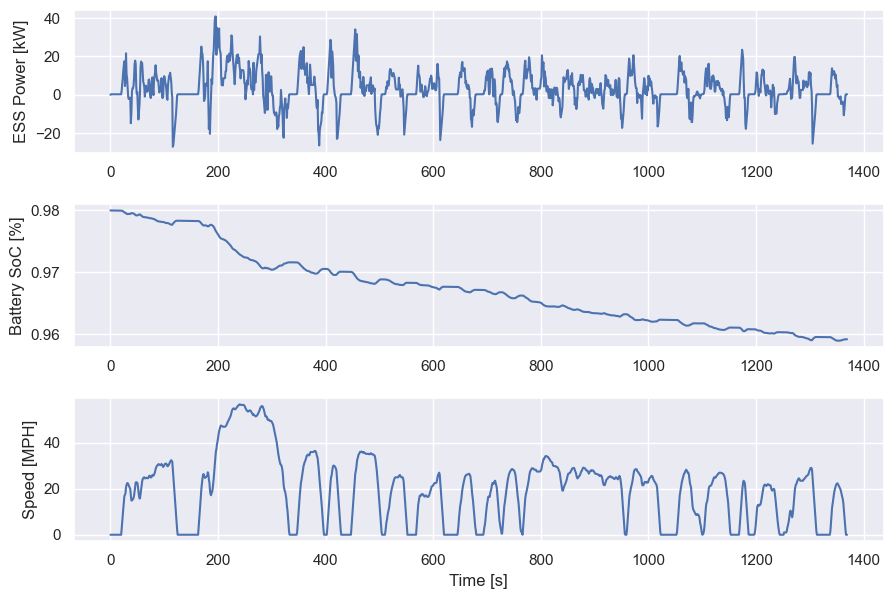

In [256]:
# Show results
print(f"{sim_drive.dist_mi.sum():f} miles")
print(f"{sim_drive.ess_kw_out_ach.sum() / 60 / 60:f} kWh")
print(f"{sim_drive.electric_kwh_per_mi:f} kWh/mi")
print(f"{1 / sim_drive.electric_kwh_per_mi:f} mi/kWh")

fig, ax = plt.subplots(3, 1, figsize=(9,6))
fig.tight_layout()
ax[0].plot(cyc.time_s, sim_drive.ess_kw_out_ach)
ax[0].set_ylabel('ESS Power [kW]')
ax[1].plot(cyc.time_s, sim_drive.soc)
ax[1].set_ylabel('Battery SoC [%]')
ax[2].plot(cyc.time_s, sim_drive.mph_ach)
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Speed [MPH]')